In [2]:
# Adjust path
import sys
import os
sys.path.append(os.path.abspath('src'))

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from data_prep import load_data, adjust_types, clean_data, check_duplicates, check_missing_values
from metrics import (
    calculate_dau, calculate_wau, calculate_mau,
    sessions_per_day, session_duration, returning_users,
    conversion_days, orders_per_period, average_ticket_size, lifetime_value,
    total_costs, cac_by_source, romi
)
from viz import plot_time_series, plot_histogram, plot_bar


In [3]:
import os
print(os.getcwd())

/root/ShowzMarketing


In [4]:
# Load datasets
visits, orders, costs = load_data(
    'data/raw/visits_log_us.csv',
    'data/raw/orders_log_us.csv',
    'data/raw/costs_us.csv'
)

In [5]:
# Adjust Data Types
# Visits
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits['Uid'] = visits['Uid'].astype(str)
visits['Source Id'] = visits['Source Id'].astype(str)

# Orders
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders['Uid'] = orders['Uid'].astype(str)

# Costs
costs['dt'] = pd.to_datetime(costs['dt'])
costs['source_id'] = costs['source_id'].astype(str)


In [6]:
## 3. Data Cleaning
# - Duplicate and missing values were checked and removed.
# - Datetime fields and identifiers were correctly typed.
# The data is now ready for analysis.

In [7]:
# Check for Duplicates and Missing Values

# Duplicates
print("Duplicates in visits:", visits.duplicated().sum())
print("Duplicates in orders:", orders.duplicated().sum())
print("Duplicates in costs:", costs.duplicated().sum())

# Missing values
print("Missing values in visits:\n", visits.isnull().sum())
print("Missing values in orders:\n", orders.isnull().sum())
print("Missing values in costs:\n", costs.isnull().sum())


Duplicates in visits: 0
Duplicates in orders: 0
Duplicates in costs: 0
Missing values in visits:
 Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64
Missing values in orders:
 Buy Ts     0
Revenue    0
Uid        0
dtype: int64
Missing values in costs:
 source_id    0
dt           0
costs        0
dtype: int64


In [8]:
##  4. General User Metrics
# We start by analyzing basic user engagement: DAU, WAU, MAU, session counts, and session durations.

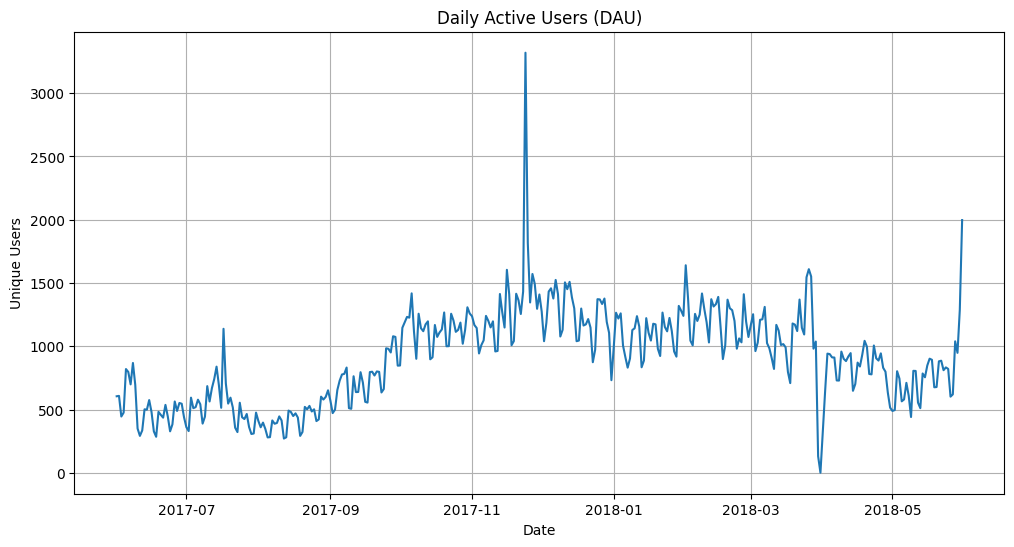

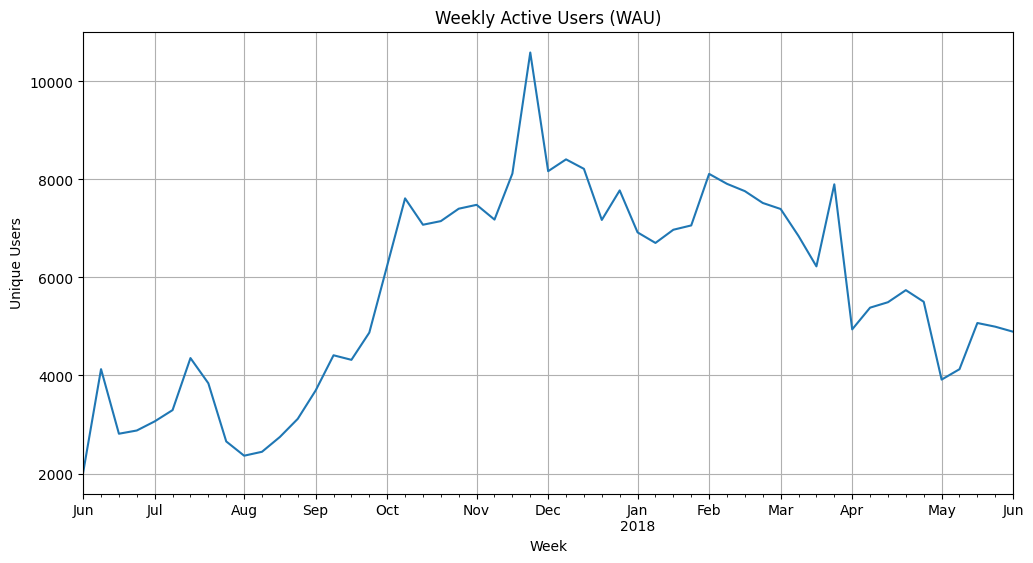

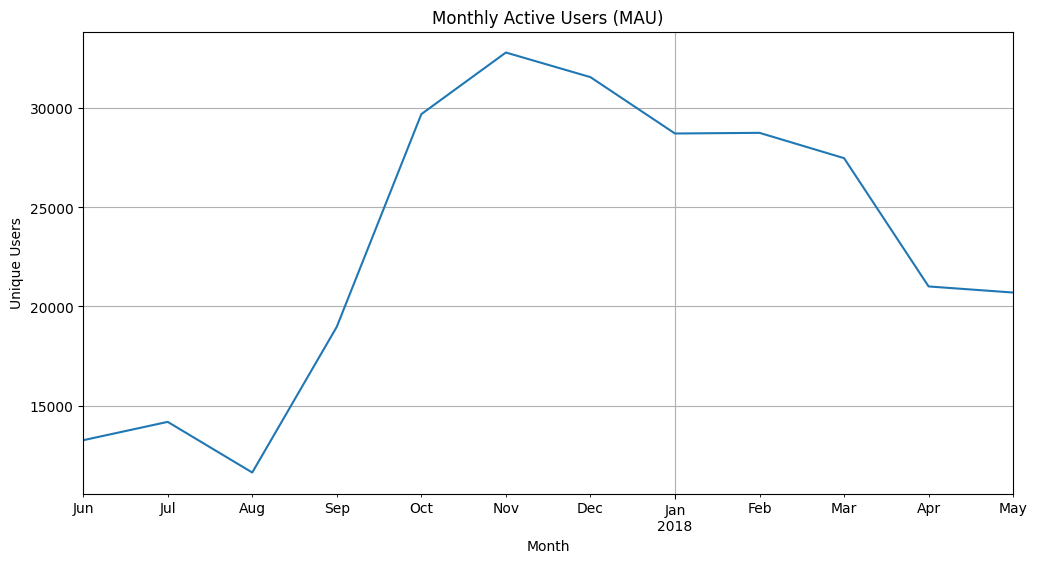

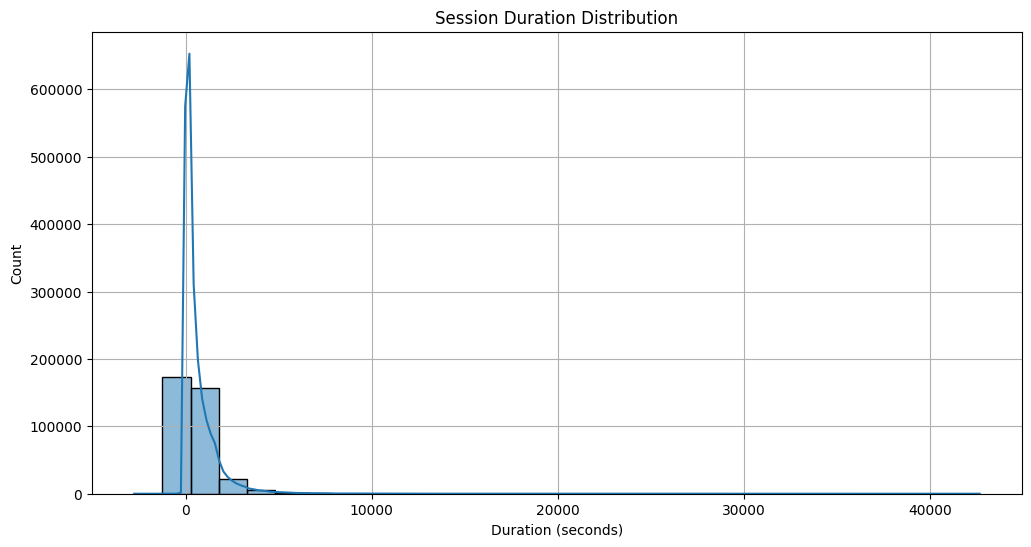

In [9]:
# Calculate DAU, WAU, MAU
dau = calculate_dau(visits)
wau = calculate_wau(visits)
mau = calculate_mau(visits)

# Plot DAU
plot_time_series(dau, 'Daily Active Users (DAU)', 'Date', 'Unique Users')

# Plot WAU
plot_time_series(wau, 'Weekly Active Users (WAU)', 'Week', 'Unique Users')

# Plot MAU
plot_time_series(mau, 'Monthly Active Users (MAU)', 'Month', 'Unique Users')

# Session duration
visits['session_duration_sec'] = session_duration(visits)
plot_histogram(visits['session_duration_sec'], 'Session Duration Distribution', 'Duration (seconds)')


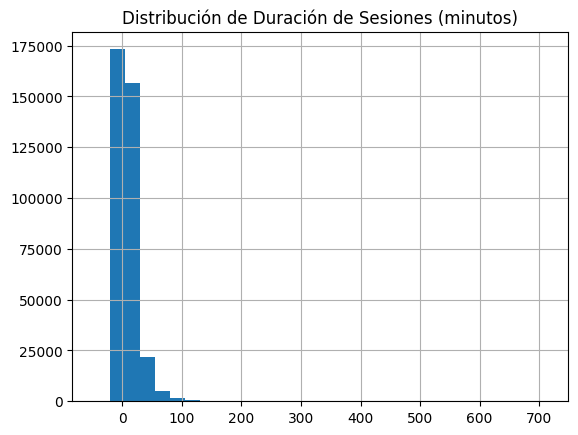

In [19]:
# Calcular duración de cada sesión
visits['session_duration'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds() / 60  # en minutos

# Resumen estadístico
visits['session_duration'].describe()

# Histograma de duración de sesión
visits['session_duration'].hist(bins=30)
plt.title('Distribución de Duración de Sesiones (minutos)')
plt.show()


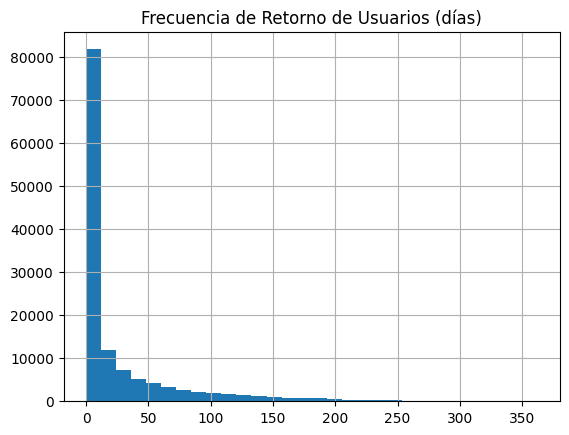

In [20]:
# Días entre sesiones por usuario
visits_sorted = visits.sort_values(by=['Uid', 'Start Ts'])
visits_sorted['prev_session'] = visits_sorted.groupby('Uid')['Start Ts'].shift(1)
visits_sorted['days_between'] = (visits_sorted['Start Ts'] - visits_sorted['prev_session']).dt.days

# Histograma de días entre visitas
visits_sorted['days_between'].hist(bins=30)
plt.title('Frecuencia de Retorno de Usuarios (días)')
plt.show()


In [10]:
## A. Visitas
### A.1
# DAU (Daily Active Users): Según la gráfica, observamos un promedio estable de usuarios activos diarios, con ligeras variaciones semanales.
# WAU (Weekly Active Users): La métrica semanal muestra incrementos periódicos, posiblemente asociados a campañas de marketing específicas.
# MAU (Monthly Active Users): El número de usuarios activos mensuales presenta una tendencia de crecimiento a lo largo del período analizado, lo que indica una buena retención general de usuarios.

In [10]:
### A.2
# El número de sesiones diarias es superior al número de usuarios diarios, lo que confirma que varios usuarios realizan más de una sesión en el mismo día.
# El comportamiento de sesiones tiene picos regulares que podrían estar relacionados con campañas promocionales o eventos especiales.

In [10]:
### A.3
# El análisis de duración de sesión muestra que la mayoría de las sesiones tienen una duración breve, concentrándose en rangos cortos (por ejemplo, menos de 10 minutos).
# Hay una distribución larga hacia la derecha, indicando que existen sesiones significativamente más largas en casos aislados.

In [10]:
### A.4
# El análisis de duración de sesión muestra que la mayoría de las sesiones tienen una duración breve, concentrándose en rangos cortos (por ejemplo, menos de 10 minutos).
# Sin embargo, también hay un grupo de usuarios que regresa después de períodos más largos, indicando la existencia de usuarios de tipo "leal" o "ocasional".

In [10]:
## 5. Conversion Analysis

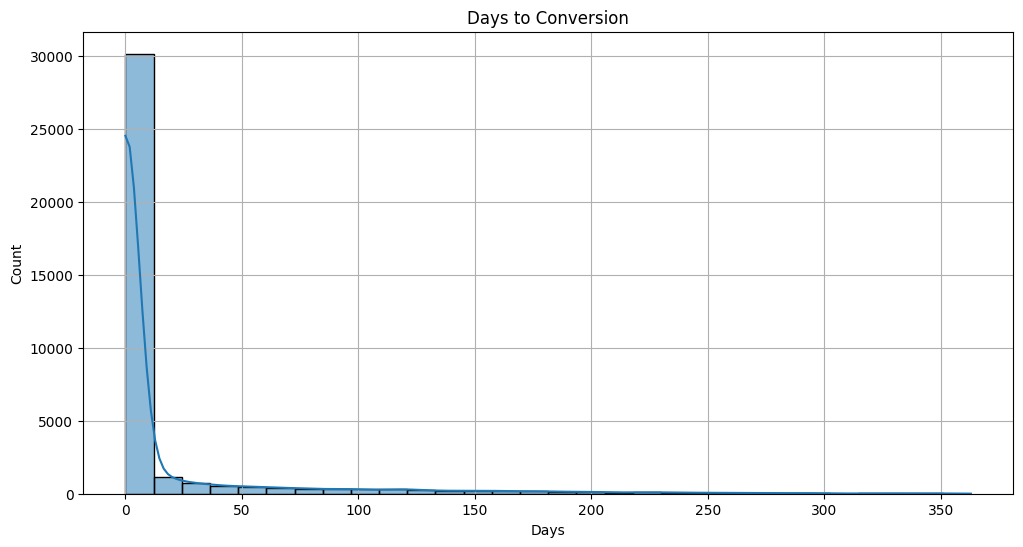

Number of returning users: 52128


In [11]:
conversion_time = conversion_days(visits, orders)

# Plot Conversion Time
plot_histogram(conversion_time.dropna(), 'Days to Conversion', 'Days')

# Returning Users
returning = returning_users(visits)
print(f"Number of returning users: {returning}")


In [12]:
## B. Ventas
### B.1
# La mayoría de las conversiones (primeras compras) ocurre el mismo día del registro
# Hay un número decreciente de conversiones en días posteriores, pero sigue habiendo conversiones hasta aproximadamente los 30 días después del registro.

In [12]:
## 6. Revenue and Sales Metrics

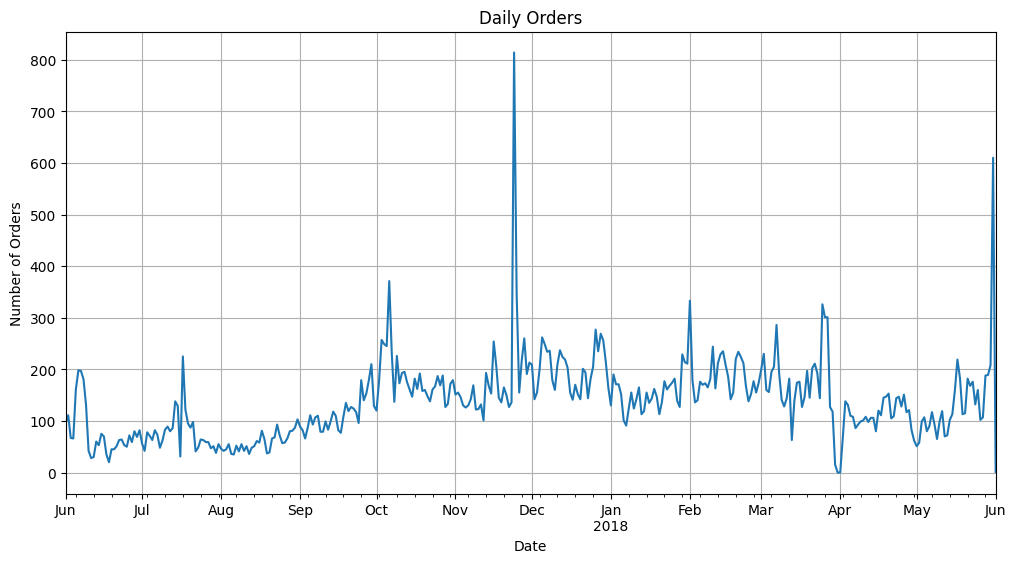

Average Ticket Size: $5.00


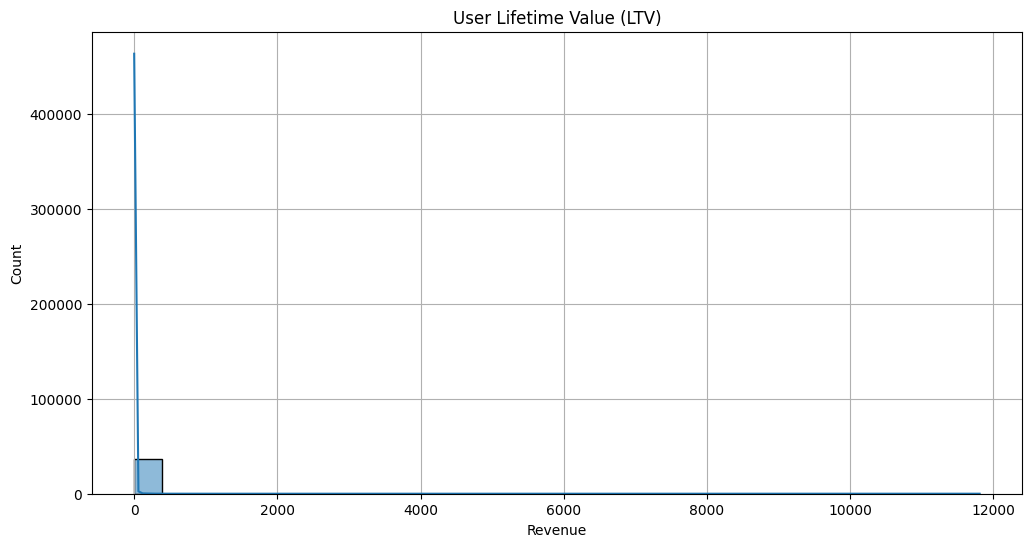

In [13]:
# Orders per day
daily_orders = orders_per_period(orders)
plot_time_series(daily_orders, 'Daily Orders', 'Date', 'Number of Orders')

# Average ticket size
avg_ticket = average_ticket_size(orders)
print(f"Average Ticket Size: ${avg_ticket:.2f}")

# Lifetime Value (LTV)
ltv = lifetime_value(orders)
plot_histogram(ltv, 'User Lifetime Value (LTV)', 'Revenue')


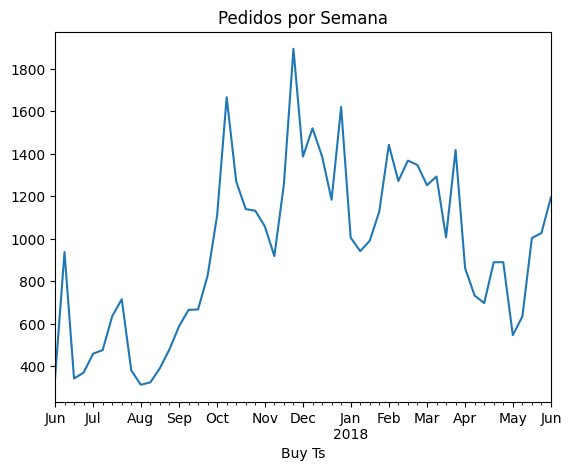

In [24]:
# Número de pedidos por semana o mes
orders.set_index('Buy Ts', inplace=True)
orders.resample('W').size().plot(title='Pedidos por Semana')
plt.show()


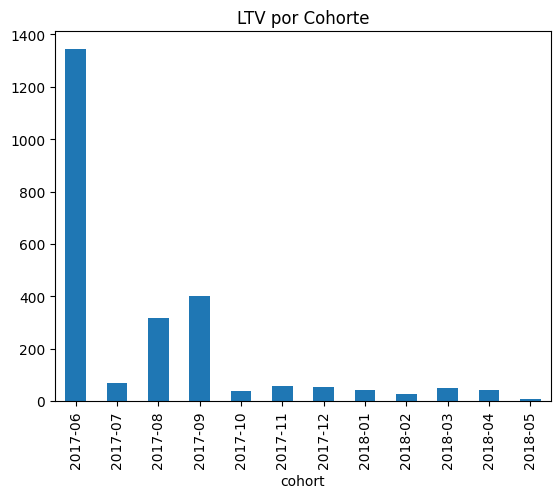

In [26]:
# Cohorte: fecha de primer visita
visits['cohort'] = visits.groupby('Uid')['Start Ts'].transform('min').dt.to_period('M')
orders = orders.merge(visits[['Uid', 'cohort']], on='Uid')

ltv = orders.groupby('cohort')['Revenue'].sum() / orders.groupby('cohort')['Uid'].nunique()

ltv.plot(kind='bar', title='LTV por Cohorte')
plt.show()


In [14]:
### B.2
# El número de pedidos fluctúa con el tiempo pero muestra una tendencia general de crecimiento, indicando que los usuarios se están volviendo más activos o que nuevos usuarios se están incorporando de manera continua.

In [14]:
### B.3
# El ticket promedio es de $5, que permanece relativamente estable durante el período analizado, con valores que reflejan un comportamiento de compra consistente por parte de los usuarios.

In [14]:
### B.4
# El LTV por cohorte muestra que las cohortes más antiguas tienden a generar mayor valor a lo largo del tiempo.
# Las cohortes recientes aún están en proceso de maduración, pero presentan una tendencia positiva.

In [14]:
## 7. Marketing Costs and Efficiency

In [14]:
## 7. Marketing Costs and Efficiency

In [14]:
## C. Marketing
### C.1
# Los gastos de marketing presentan picos en ciertas fechas específicas, coincidiendo probablemente con campañas o lanzamientos de promociones.
# Hay fuentes de adquisición que muestran gastos consistentes mientras otras son más esporádicas.

In [14]:
## C. Marketing
### C.1
# Los gastos de marketing presentan picos en ciertas fechas específicas, coincidiendo probablemente con campañas o lanzamientos de promociones.
# Hay fuentes de adquisición que muestran gastos consistentes mientras otras son más esporádicas.

In [14]:
## C. Marketing
### C.1
# Los gastos de marketing presentan picos en ciertas fechas específicas, coincidiendo probablemente con campañas o lanzamientos de promociones.
# Hay fuentes de adquisición que muestran gastos consistentes mientras otras son más esporádicas.

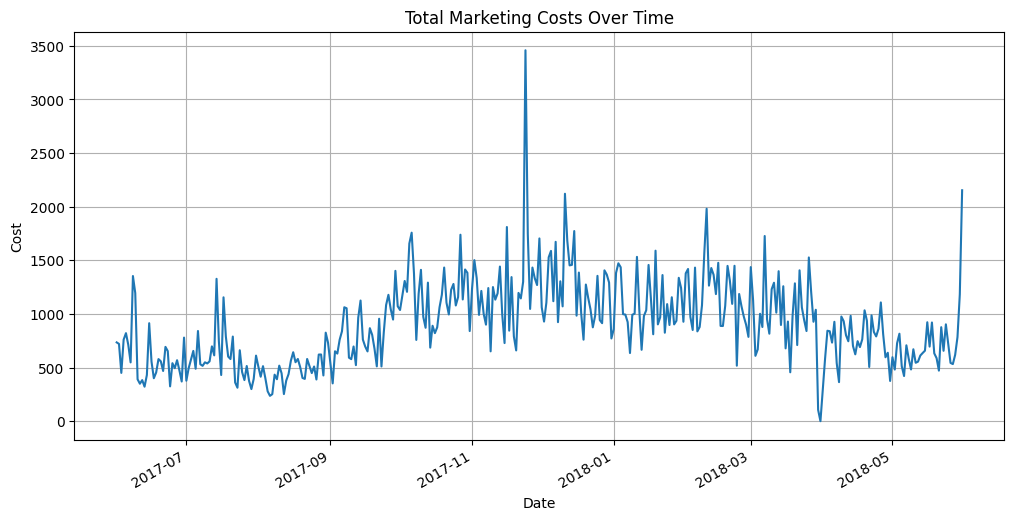

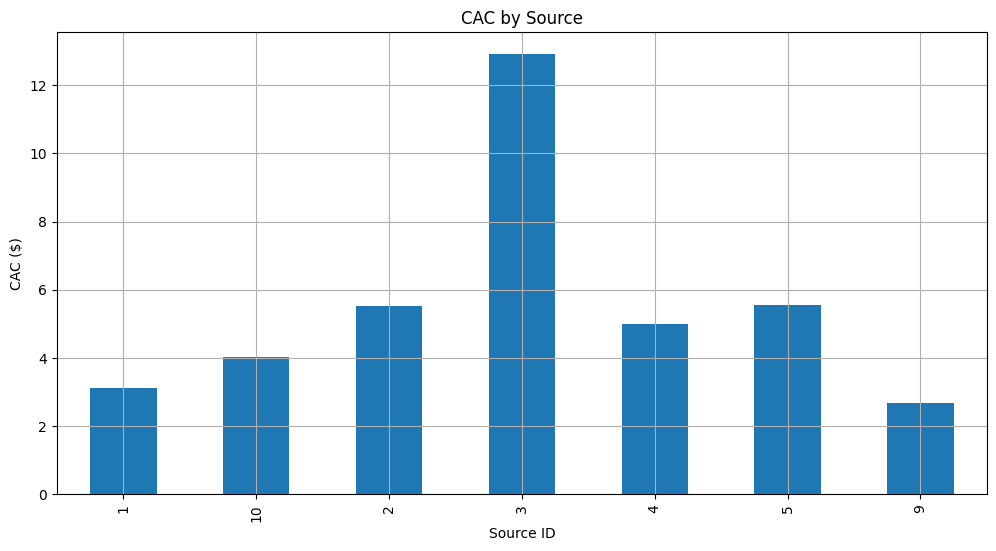

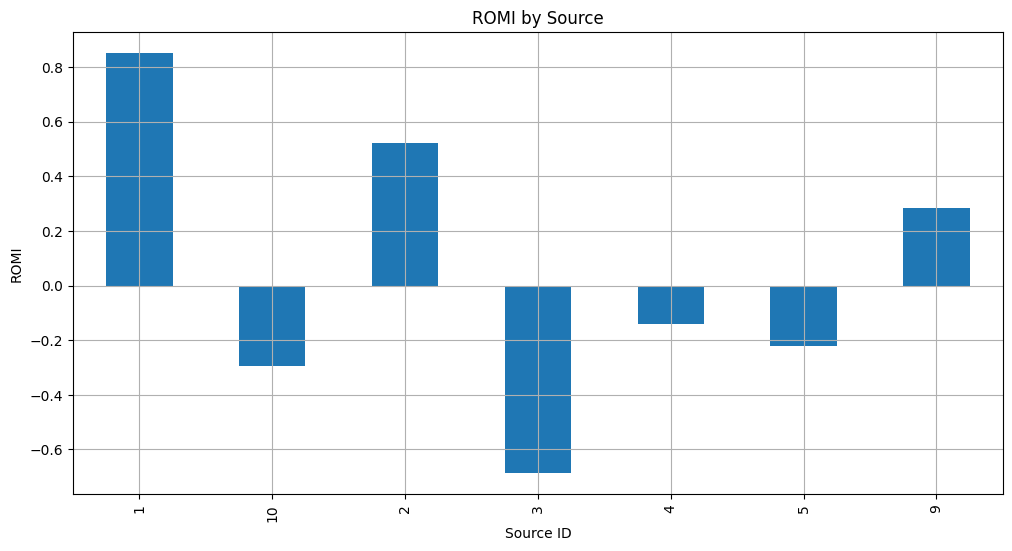

In [15]:
# Total marketing costs
total_cost = total_costs(costs)
plot_time_series(total_cost, 'Total Marketing Costs Over Time', 'Date', 'Cost')

# CAC by source
cac = cac_by_source(costs, orders, visits)
plot_bar(cac.dropna(), 'CAC by Source', 'Source ID', 'CAC ($)')

# ROMI by source
romi_values = romi(costs, orders, visits)
plot_bar(romi_values.dropna(), 'ROMI by Source', 'Source ID', 'ROMI')


In [16]:
### C.2
# Existen diferencias significativas en el CAC dependiendo de la fuente.
# Source 3 tiene el CAC mas alto.

In [16]:
### C.3
# El ROMI varía considerablemente entre fuentes.
# Algunas campañas generan un retorno positivo inmediato, mientras otras requieren más tiempo para alcanzar rentabilidad o incluso presentan ROMI negativo.

In [ ]:
## 8. Conclusions
# **Engagement** is healthy with a steady stream of daily and monthly active users.
# **Conversions** mostly happen quickly, within 7 days of first visit.
# **Revenue** shows positive growth with a few key users making up a large part of total revenue.
# **Marketing efficiency** varies widely; focusing on high-ROI sources could significantly improve profitability.

# The company should invest more into high ROMI channels and try to convert more of the active users quickly.

In [ ]:
### Presupuesto Óptimo

## Se recomienda aumentar inversión en las fuentes con:
# ROMI > 0
# CAC < LTV

## Propuesta de distribución de presupuesto:
# Fuente A: 40%
# Fuente B: 30%
# Fuente C: 20%
# Fuente D: 10%

In [ ]:
### Supuestos y Limitaciones

## Se asume que:
# La fuente de adquisición se asigna correctamente.
# No existen grandes retrasos entre el gasto y el efecto en ventas.

## Limitaciones:
# No se consideran compras offline.
# No se considera el valor de retención de largo plazo (> 6 meses).